## Analyzing student test data

We are given with 5 collections from a MongoDB database
Each collection details are given below.

1. attempts: It holds summary data of student's attempt. Each test by a student becomes an attempt. If student takes 5 tests (same or different test), it will create 5 attempts. If student abandones the test, isAbandon flag is set to true. We consider only isAbandon = false documents. 

2. attemptDetails: Question level details such as time taken on each question can be found in this collection. Each attempt has a corresponding attemptDetails.

3. practicesets: List of tests. Array 'questions' holds list of questions. Test can be created organically or can be created from the questions of question pool.

4. questions: list of questions. One question can be part of many tests. Question can be put in the pool using flag 'isAllowReuse'

5. grades/subjects/topics - master data of exam, related subjects and topics

6. users: list of students including teachers and parents

## Objective:
1. Does more practice mean better performance?
2. Detect fraud done by some test takers. Fraud can be based on
    - Number of consecutive correct answers
    - Time spent on each questions when answer is correct
    - Time spent outside the test window (offscreen time)
    - Time spent by other users of similar profile on this question
    - Strength and weakness of the student on the topic
    - Time spent by the student on similar questions
3. Student clusters based on different attributes e.g. performance, time spent, consistency, participation in discussion etc
4. A teacher may mark a question easy/medium/hard (Perceived hardness) but we want to give feedback to teachers on what's real hardness based on student's data (how many students answered correctly, how much time taken, whether student was good in the area/topic etc. )
5. Predict score in a test and challenge student to beat it 

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from pymongo import mongo_client
from pymongo import MongoClient
from pandas.io.json import json_normalize
import json
import warnings
warnings.filterwarnings('ignore')

In [2]:
client = MongoClient('localhost', 27017)

In [3]:
# lets see the database names
client.list_database_names()

['admin', 'config', 'local', 'localdb']

In [4]:
db = client.localdb

In [5]:
# lets see the total collection names present in the internshalla database
collect_names = db.list_collection_names()

In [6]:
collect_names

['topics',
 'attempts',
 'users',
 'practicesets',
 'attemptdetails',
 'grades',
 'questions',
 'subjects']

In [7]:
users_df = json_normalize(list(db.users.find()))
attempts_df = json_normalize(list(db.attempts.find()))
grades_df = json_normalize(list(db.grades.find()))
practicesets_df = json_normalize(list(db.practicesets.find()))
topics_df = json_normalize(list(db.topics.find()))
subjects_df = json_normalize(list(db.subjects.find()))
questions_df = json_normalize(list(db.questions.find()))
attemptdetails_df = json_normalize(list(db.attemptdetails.find()))

## Data wrangling

In [8]:
# Lets see the first five rows of attempts_df
attempts_df.head()

,__v,_id,attemptType,attemptdetails,createdAt,createdBy.name,createdBy.user,email,idOffline,isAbandoned,...,totalCorrects,totalErrors,totalMark,totalMarkeds,totalMissed,totalQuestions,totalTime,updatedAt,user,userId
0,0,5b851ff7dd6c9c8cedb051d3,NaN,5b851ff7dd6c9c400eb051d4,2018-08-28 09:17:00.084,teacherlpu,5b3e0266a14b7e000d9cc040,None,None,False,...,25,9,25.0,0,21,55,3299999,2018-08-28 10:12:21.337,5b82922cdd6c9c2801b00f20,NaN
1,0,5b851ffdb0a5d1ad413d8301,NaN,5b851ffdb0a5d17a103d8302,2018-08-28 09:23:57.839,teacherlpu,5b3e0266a14b7e000d9cc040,None,None,False,...,35,20,35.0,0,0,55,2887958,2018-08-28 10:12:25.489,5b82922edd6c9c6e6db00fb0,NaN
2,0,5b852003b0a5d136aa3d8371,NaN,5b852003b0a5d190863d8372,2018-08-28 09:17:11.950,teacherlpu,5b3e0266a14b7e000d9cc040,None,None,False,...,31,24,31.0,0,0,55,3300006,2018-08-28 10:12:39.239,5b829227dd6c9c4c7fb00da0,NaN
3,0,5b852014b0a5d10fc33d83e4,NaN,5b852014b0a5d11fd13d83e5,2018-08-28 09:17:28.725,teacherlpu,5b3e0266a14b7e000d9cc040,None,None,False,...,29,15,29.0,0,11,55,3300049,2018-08-28 10:12:59.708,5b82922add6c9c5f61b00e6a,NaN
4,0,5b85200948598b0aa6eabf57,NaN,5b85200948598b0d5beabf58,2018-08-28 09:17:16.906,teacherlpu,5b3e0266a14b7e000d9cc040,None,None,False,...,16,19,16.0,0,20,55,3300005,2018-08-28 10:12:38.440,5b82922edd6c9cd998b00f86,NaN


In [9]:
attemptdetails_df.head()

,QA,__v,_id,attempt,createdAt,isAbandoned,practicesetId,updatedAt,user
0,"[{'question': 5b82ecb0dd6c9c00e1b01857, 'timeE...",0,5b83d5723a227f518ce1770b,5b83d5723a227f350be1770a,2018-08-27 10:41:54.195,False,5b82ecb0dd6c9c3785b01856,2018-08-27 10:41:54.195,5b82922edd6c9c0c57b00f90
1,"[{'question': 5b82ecb0dd6c9c00e1b01857, 'timeE...",0,5b83d57edd6c9c2b7db02a8f,5b83d57edd6c9c8ec5b02a8e,2018-08-27 10:42:06.566,False,5b82ecb0dd6c9c3785b01856,2018-08-27 10:42:06.566,5b82922edd6c9c52c9b00fbe
2,"[{'question': 5b82ecb0dd6c9c00e1b01857, 'timeE...",0,5b83d566af15dcb2402312df,5b83d566af15dc6d322312de,2018-08-27 10:41:42.351,False,5b82ecb0dd6c9c3785b01856,2018-08-27 10:41:42.351,5b82922cdd6c9c67f5b00ef6
3,"[{'question': 5b82ecb0dd6c9c00e1b01857, 'timeE...",0,5b83d58c48598b0d31ea8a8c,5b83d58c48598bec32ea8a8b,2018-08-27 10:42:20.879,False,5b82ecb0dd6c9c3785b01856,2018-08-27 10:42:20.879,5b829227dd6c9c9dacb00da2
4,"[{'question': 5b82ecb0dd6c9c00e1b01857, 'timeE...",0,5b83d5a9af15dcb31c23133a,5b83d5a9af15dc547a231339,2018-08-27 10:42:49.989,False,5b82ecb0dd6c9c3785b01856,2018-08-27 10:42:49.989,5b829229dd6c9c8536b00e4c


In [10]:
users_df.head()

,__v,_id,about,avatar._id,avatar.fileName,avatar.fileUrl,avatar.mimeType,avatar.path,avatar.size,avatarMD._id,...,state,status,streamUrl,street,studentExclusive,theme,trainingCertifications,updatedAt,userId,web
0,1,5ba5de707fd1c552b32712cd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,,True,,NaN,False,NaN,NaN,2018-09-22 06:17:20.076,9035735367,NaN
1,1,5ba5dcff7fd1c5f9e62710b0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,,True,,NaN,False,NaN,NaN,2018-09-22 06:11:11.959,8563968516,NaN
2,2,5ba5dd217fd1c56a6e2710f8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Punjab,True,,NaN,False,NaN,NaN,2018-09-22 06:11:45.281,9591871089,NaN
3,2,5ba5dd1d7fd1c5a3fb2710f2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Punjab,True,,NaN,False,NaN,NaN,2018-09-22 06:11:41.955,d8o2oank.iamna@gmail.com,NaN
4,1,5ba5dd1b7fd1c520c12710ee,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,,True,,NaN,False,NaN,NaN,2018-09-22 06:11:39.601,s6o9mreasdhzdufo@gmail.com,NaN


In [11]:
grades_df.head()

,ShortName,__v,_id,active,adaptive,countryCode,createdAt,empIndex,isDefault,levels,moveType,name,slugfly,subjects,updatedAt,view
0,CSE,0.0,08eddbadc8f640739faf75c9,True,False,IN,2017-10-28T03:01:43,NaN,False,NaN,2.0,Computer Science & Engineering,computer-science--engineering,"[61f5644288f644cab26f2309, 63dae9572c4944408bc...",2017-10-28T03:01:43,NaN
1,CVL,0.0,d51036e3049840aeab2bb394,True,False,IN,2017-08-31T10:39:23,NaN,False,NaN,2.0,Civil Engineering,civil-engineering,"[56bd5fc60799471c90a7f5ea, 74296ce7aa304946b56...",2017-08-31T10:39:23,banking.html
2,EE,0.0,7208f2fa733b4062a7a132b7,True,False,IN,2017-10-13T12:08:01,NaN,False,NaN,2.0,Electrical Engineering,electrical-engineering,"[47b4f450946647839d63fb3a, f3d89ecae0f04065a10...",2017-10-13T12:08:01,NaN
3,Psy,NaN,5bacca975cb8c3baf1c24301,True,False,IN,2018-09-27 12:18:32.640000,NaN,True,NaN,NaN,Psychometric Test,psychometric-test,"[5bacca975cb8c3baf1c24302, 5bacca975cb8c3baf1c...",2018-09-27 12:18:32.640000,NaN
4,PRT,0.0,b0e56effc8ff4d969c41c40c,True,False,IN,2017-03-30T11:14:17,True,True,"[{'name': 'Level 1', 'value': 1.0}, {'name': '...",2.0,Placement Readiness Tests,placement-readiness-tests,"[a262c47026a44718acd41306, e8cfb0328cda490ca3e...",2017-03-30T11:14:17,NaN


In [12]:
topics_df.head()

,__v,_id,active,createdAt,name,slugfly,subject,updatedAt
0,0.0,364b1e914cde49009f85fdc0,True,2017-08-31T10:39:23,Bricks,bricks,56bd5fc60799471c90a7f5ea,2017-08-31T10:39:23
1,0.0,acff5e04a13849be9f031bd4,True,2017-08-31T10:39:24,Plastics,plastics,56bd5fc60799471c90a7f5ea,2017-08-31T10:39:24
2,0.0,0e2e57dd349244c19b819f69,True,2017-08-31T10:39:24,Laplace Transform,laplace-transform,9c6bdbbdab294f3588ed7bb4,2017-08-31T10:39:24
3,0.0,abe0ee362189418c830660e3,True,2017-08-31T10:39:24,"Gradient, Divergence & Curl",gradient-divergence--curl,9c6bdbbdab294f3588ed7bb4,2017-08-31T10:39:24
4,0.0,33793df021c84600955ca6a0,True,2017-08-31T10:39:24,Miscellaneous,miscellaneous,9c6bdbbdab294f3588ed7bb4,2017-08-31T10:39:24


In [13]:
subjects_df.head()

,__v,_id,active,countryCode,createdAt,grade,levels,name,slugfly,status,topics,updatedAt
0,0.0,56bd5fc60799471c90a7f5ea,True,IN,2017-08-31 10:39:23.000,d51036e3049840aeab2bb394,"[{'name': 'Level 1', 'value': 1.0, 'quantity':...",Building Materials,building-materials,NaN,"[a17bda239e15484cb6f140bb, 2d713187b82343cea94...",2017-08-31 10:39:23.000
1,0.0,5ac5e5d6bb5152000d09e0bb,True,IN,2018-04-05 09:01:10.792,d51036e3049840aeab2bb394,"[{'name': 'Level 1', 'value': 1.0, 'quantity':...",Civil Engineering Design & Construction,civil-engineering-design-and-construction,NaN,"[5ac5e5f0bb5152000d09e0bc, 5ac5e5fdbb5152000d0...",2018-04-05 09:01:10.792
2,0.0,5ab2629e792f9e000be365d4,True,IN,2018-03-21 13:48:14.212,d51036e3049840aeab2bb394,"[{'name': 'Level 1', 'value': 1.0, 'quantity':...",Ground Improvement Engineering,ground-improvement-engineering,NaN,"[5ab262c2792f9e000be365d5, 5ab262d5792f9e000be...",2018-03-21 13:48:14.212
3,0.0,1dffcbf055484c1aa1bc31db,True,IN,2017-08-31 10:39:24.000,d51036e3049840aeab2bb394,"[{'name': 'Level 1', 'value': 1.0, 'quantity':...",General Aptitude,general-aptitude,NaN,"[e7bd923b78634c9ca70e12f4, ee2a0ee380aa4405b2c...",2017-08-31 10:39:24.000
4,0.0,5ab098cd0f7749000ba1c331,True,IN,2018-03-20 05:14:53.218,d51036e3049840aeab2bb394,"[{'name': 'Level 1', 'value': 1.0, 'quantity':...",Construction Methods and Equipments,construction-methods-and-equipments,NaN,"[5ab098ee0f7749000ba1c332, 5ab099230f7749000ba...",2018-03-20 05:14:53.218


In [175]:
attempts_df.user[10000]

ObjectId('5c0091d05e6efb28585aa3f9')

In [15]:
'5b82922cdd6c9c2801b00f20' in attempts_df.user

False

In [178]:
attempts_df.columns

Index(['__v', '_id', 'attemptType', 'attemptdetails', 'createdAt',
       'createdBy.name', 'createdBy.user', 'email', 'idOffline', 'isAbandoned',
       'isAnsync', 'isCratedOffline', 'isEvaluated', 'isShowAttempt',
       'isfraudelent', 'maximumMarks', 'minusMark', 'offscreenTime', 'partial',
       'pending', 'plusMark', 'practiceSetInfo.accessMode',
       'practiceSetInfo.classRooms', 'practiceSetInfo.createdBy',
       'practiceSetInfo.grades._id', 'practiceSetInfo.grades.level',
       'practiceSetInfo.grades.name', 'practiceSetInfo.subject',
       'practiceSetInfo.title', 'practiceSetInfo.titleLower', 'practicesetId',
       'studentName', 'subjects', 'totalCorrects', 'totalErrors', 'totalMark',
       'totalMarkeds', 'totalMissed', 'totalQuestions', 'totalTime',
       'updatedAt', 'user', 'userId'],
      dtype='object')

In [177]:
attempts_df.loc[attempts_df['user']== attempts_df.user[10000]]

,__v,_id,attemptType,attemptdetails,createdAt,createdBy.name,createdBy.user,email,idOffline,isAbandoned,...,totalCorrects,totalErrors,totalMark,totalMarkeds,totalMissed,totalQuestions,totalTime,updatedAt,user,userId
5798,0,5c0936d248b35c48c8df80eb,NaN,5c0936d248b35c3b23df80ec,2018-12-06 14:28:05.183,Vinayak,5bafb3624d7a399cc1b3f6df,k8o9uasntnaavm.@gmail.com,None,False,...,7,7,7.0,0,1,15,1200005,2019-02-09 06:00:06.794,5c0091d05e6efb28585aa3f9,k8o9uasntnaavm.@gmail.com
5801,0,5c093ba948b35c5fb6df8144,NaN,5c093ba948b35c1bb7df8145,2018-12-06 14:48:47.213,Vinayak,5bafb3624d7a399cc1b3f6df,k8o9uasntnaavm.@gmail.com,None,False,...,10,5,10.0,0,0,15,1195628,2019-02-09 06:00:06.794,5c0091d05e6efb28585aa3f9,k8o9uasntnaavm.@gmail.com
5804,0,5c093e7648b35cbda4df816d,NaN,5c093e7648b35c6385df816e,2018-12-06 15:12:51.337,Vinayak,5bafb3624d7a399cc1b3f6df,k8o9uasntnaavm.@gmail.com,None,False,...,15,0,15.0,0,0,15,469292,2019-02-09 06:00:06.794,5c0091d05e6efb28585aa3f9,k8o9uasntnaavm.@gmail.com
6197,0,5c0a864e48b35c132fdf88a6,NaN,5c0a864e48b35c1498df88a7,2018-12-07 14:36:03.713,Vinayak,5bafb3624d7a399cc1b3f6df,k8o9uasntnaavm.@gmail.com,None,False,...,10,5,10.0,0,0,15,204605,2019-02-09 16:04:06.392,5c0091d05e6efb28585aa3f9,k8o9uasntnaavm.@gmail.com
6200,0,5c0a874048b35c3792df88c8,NaN,5c0a874048b35c6e7fdf88c9,2018-12-07 14:41:55.289,Vinayak,5bafb3624d7a399cc1b3f6df,k8o9uasntnaavm.@gmail.com,None,False,...,13,2,13.0,0,0,15,94917,2019-02-09 16:04:06.392,5c0091d05e6efb28585aa3f9,k8o9uasntnaavm.@gmail.com
6205,0,5c0a87e748b35c7649df88e9,NaN,5c0a87e748b35c725ddf88ea,2018-12-07 14:44:51.817,Vinayak,5bafb3624d7a399cc1b3f6df,k8o9uasntnaavm.@gmail.com,None,False,...,15,0,15.0,0,0,15,85542,2019-02-09 16:04:06.392,5c0091d05e6efb28585aa3f9,k8o9uasntnaavm.@gmail.com
7055,0,5c0bc38e48b35c4bf3df92d1,NaN,5c0bc38e48b35c066cdf92d2,2018-12-08 13:06:13.723,Vinayak,5bafb3624d7a399cc1b3f6df,k8o9uasntnaavm.@gmail.com,None,False,...,8,7,8.0,0,0,15,409403,2019-02-07 13:13:08.399,5c0091d05e6efb28585aa3f9,k8o9uasntnaavm.@gmail.com
7059,0,5c0bc51448b35c1ef5df92f3,NaN,5c0bc51448b35cccb7df92f4,2018-12-08 13:16:13.881,Vinayak,5bafb3624d7a399cc1b3f6df,k8o9uasntnaavm.@gmail.com,None,False,...,15,0,15.0,0,0,15,198857,2019-02-07 13:13:08.399,5c0091d05e6efb28585aa3f9,k8o9uasntnaavm.@gmail.com
7868,0,5c0cfef0f4478b993801d4d0,NaN,5c0cfef0f4478bbfd601d4d1,2018-12-09 11:36:18.679,Vinayak,5bafb3624d7a399cc1b3f6df,k8o9uasntnaavm.@gmail.com,None,False,...,0,2,0.0,0,13,15,140510,2019-02-08 17:08:51.426,5c0091d05e6efb28585aa3f9,k8o9uasntnaavm.@gmail.com
7872,0,5c0d009ff4478b442501d517,NaN,5c0d009ff4478b7df301d518,2018-12-09 11:39:50.844,Vinayak,5bafb3624d7a399cc1b3f6df,k8o9uasntnaavm.@gmail.com,None,False,...,13,2,13.0,0,0,15,361390,2019-02-08 17:08:51.426,5c0091d05e6efb28585aa3f9,k8o9uasntnaavm.@gmail.com


In [19]:
attempts_df.userId.shape

(35737,)

In [20]:
attempts_df.shape

(35737, 43)

In [21]:
attempts_df.userId.value_counts().sum()

32175

In [22]:
attempts_df.userId[10000]

'k8o9uasntnaavm.@gmail.com'

In [23]:
'k8o9uasntnaavm.@gmail.com' in attempts_df.userId

False

In [24]:
attempts_df.userId[10000] in attempts_df.userId

False

In [25]:
type(attempts_df.userId[10000])

str

In [26]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6107 entries, 0 to 6106
Data columns (total 80 columns):
__v                       6107 non-null int64
_id                       6107 non-null object
about                     932 non-null object
avatar._id                331 non-null object
avatar.fileName           331 non-null object
avatar.fileUrl            331 non-null object
avatar.mimeType           331 non-null object
avatar.path               331 non-null object
avatar.size               331 non-null float64
avatarMD._id              78 non-null object
avatarMD.fileName         78 non-null object
avatarMD.fileUrl          78 non-null object
avatarMD.mimeType         78 non-null object
avatarMD.path             78 non-null object
avatarMD.size             78 non-null float64
avatarSM._id              78 non-null object
avatarSM.fileName         78 non-null object
avatarSM.fileUrl          78 non-null object
avatarSM.mimeType         78 non-null object
avatarSM.path             

In [27]:
attempts_df.groupby(['userId','user','_id']).count().head(30)

__v  \
userId                    user                     _id                             
0i0h0srnaagvhu@gmail.com  5c0092365e6efb28585ab23b 5c5147fa64f45e056012e548    1   
                                                   5c5ebf0b408e73409fd85a2b    1   
                                                   5c5ec2b84c010cc7bfa274da    1   
                                                   5c5ec34b4c010cb6dba27742    1   
                                                   5c5eca7e17fa2345f73d421b    1   
1423k2a1ulsah@gmail.com   5c0092355e6efb28585ab1ff 5c2e1a431d89aafa0f7fe213    1   
                                                   5c2ef0b21d89aa01487fe659    1   
                                                   5c2ef1b01d89aa0da47fe66a    1   
                                                   5c2ef7651d89aa57d97fe691    1   
                                                   5c2ef7fa1d89aaf87d7fe6b2    1   
                                                   5c2ef92a1d89aa438d7feeb7    1   
                                                   5c2f167119296408f6cedc19    1   
                                                   5c51481b7db76c607a01c31b    1   
                                                   5c5e588617fa23096c3c2cea    1   
                                                   5c5e5fae1c17e3dd6c6b0ad6    1   
                                                   5c5e66e71c17e388816b22a2    1   
1h2a3uvraasbkra@gmail.com 5ba89910db4cd83f946e9f57 5c5ea45d408e73652dd81161    1   
                                                   5c5eade717fa2303a73cb56f    1   
1h9sveihs@gmail.com       5c0092675e6efb28585ab8a3 5c10afca921dff3851ad6e35    1   
                                                   5c13b2627e962cac2bca2e39    1   
                                                   5c13b3667e962c00c2ca2e5e    1   
                                                   5c150f741bf97bf1b6e677ad    1   
                                                   5c51399ad375143673656843    1   
                                                   5c51491da7d3bd4578080bfb    1   
                                                   5c5ebcec17fa2320dc3cf7ab    1   
                                                   5c5ec33117fa2351943d277f    1   
                                                   5c5ec51417fa2378023d31ab    1   
1i4h.ssnuary@gmail.com    5c0091d05e6efb28585aa3f4 5c0fb6ca475e1847480d2aa6    1   
                                                   5c0fb915475e1809620d2aca    1   
                                                   5c0fc30d475e181b100d2b54    1   

                                                                             attemptType  \
userId                    user                     _id                                     
0i0h0srnaagvhu@gmail.com  5c0092365e6efb28585ab23b 5c5147fa64f45e056012e548            0   
                                                   5c5ebf0b408e73409fd85a2b            0   
                                                   5c5ec2b84c010cc7bfa274da            0   
                                                   5c5ec34b4c010cb6dba27742            0   
                                                   5c5eca7e17fa2345f73d421b            0   
1423k2a1ulsah@gmail.com   5c0092355e6efb28585ab1ff 5c2e1a431d89aafa0f7fe213            0   
                                                   5c2ef0b21d89aa01487fe659            0   
                                                   5c2ef1b01d89aa0da47fe66a            0   
                                                   5c2ef7651d89aa57d97fe691            0   
                                                   5c2ef7fa1d89aaf87d7fe6b2            0   
                                                   5c2ef92a1d89aa438d7feeb7            0   
                                                   5c2f167119296408f6cedc19            0   
                                                   5c51481b7db76c607a01c31b            0   
        

In [28]:
# from the problem statement we know that we only work with test attempts where isAbandoned is set to False
# Lets see whether any student abandoned the test
attempts_df.isAbandoned.value_counts()

False    33946
True      1791
Name: isAbandoned, dtype: int64

1. so there are total 33946 observations where student took the complete test
2. and 1791 observations or students abondoned the test
3. So according to problem statement we only work with observations where student took test
4. So I will delete all the observation having isAbandoned equal to True

I will create a new final_df dataframe so that we can add all the necessary columns from all the collections and do our final anlysis in based on one data frame

In [29]:
final_df = attempts_df

In [30]:
final_df.drop(final_df[final_df['isAbandoned'] == True].index, inplace=True)

In [31]:
# lets relook whether every observation with True Abandoned is deleted from dataframe
final_df.isAbandoned.value_counts()

False    33946
Name: isAbandoned, dtype: int64

In [32]:
# great everything with true value of isAbandoned is deleted from our final_df dataframe
# lets check whether there any null values are present in our dataset

In [33]:
# lets get some more information of attempts_df
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33946 entries, 0 to 35736
Data columns (total 43 columns):
__v                             33946 non-null int64
_id                             33946 non-null object
attemptType                     0 non-null float64
attemptdetails                  33946 non-null object
createdAt                       33946 non-null datetime64[ns]
createdBy.name                  33936 non-null object
createdBy.user                  33936 non-null object
email                           30370 non-null object
idOffline                       4630 non-null object
isAbandoned                     33946 non-null bool
isAnsync                        33946 non-null bool
isCratedOffline                 33946 non-null bool
isEvaluated                     33946 non-null bool
isShowAttempt                   33946 non-null bool
isfraudelent                    33946 non-null bool
maximumMarks                    33946 non-null int64
minusMark                       33946

1. So there are total 33946 attempts or observations and 43 features or columns.
2. We can see that attemptType feature has all null values, so we can ignore that feature.
3. We can also see out of 33946 values, feature has 30370 non null values.
4. idOffline has only 4630 non null values.
5. userId has 30596 non null values out of 33946 values, so 3,350 attempts doesn't have userId's
6. But we can also see that user feature has no null values.
7. Let's see whether we can use user_df or user collection from our database to fill those null userId's based on there user values.
8. Apart from the above mentioned features, no other features has null values.

<b> Lets looks at the unique values of all the features and decide which features are important for our analysis</b>

In [34]:
final_df.subjects[0]

[{'_id': ObjectId('a262c47026a44718acd41306'),
  'accuracy': 0.72,
  'correct': 18,
  'incorrect': 7,
  'mark': 18,
  'maxMarks': 25,
  'missed': 0,
  'name': 'Verbal Ability',
  'offscreenTime': 0,
  'partial': 0,
  'pending': 0,
  'speed': 33452.24,
  'topics': [{'_id': ObjectId('5b3e1717a14b7e000d9cc6e5'),
    'accuracy': 0.2,
    'correct': 1,
    'incorrect': 4,
    'mark': 1,
    'maxMarks': 5,
    'missed': 0,
    'name': 'Subject - Verb Agreement',
    'partial': 0,
    'pending': 0,
    'speed': 38287},
   {'_id': ObjectId('5b3e1734a14b7e000d9cc6e6'),
    'accuracy': 0.5,
    'correct': 3,
    'incorrect': 3,
    'mark': 3,
    'maxMarks': 6,
    'missed': 0,
    'name': 'Adjectives & Adverbs',
    'partial': 0,
    'pending': 0,
    'speed': 39228.666666666664},
   {'_id': ObjectId('245fa9d1d09b45ecb69dd631'),
    'accuracy': 1,
    'correct': 3,
    'incorrect': 0,
    'mark': 3,
    'maxMarks': 3,
    'missed': 0,
    'name': 'Antonyms',
    'partial': 0,
    'pending': 0,


In [35]:
# as the subjects feature has nested information we are ignoring from unique values as of now
for col in final_df.columns:
    if col == 'subjects':
        pass
    else: 
        print('{} has total unique values of {}'.format(col, final_df[col].value_counts().shape[0]))

__v has total unique values of 1
_id has total unique values of 33946
attemptType has total unique values of 0
attemptdetails has total unique values of 33946
createdAt has total unique values of 33875
createdBy.name has total unique values of 15
createdBy.user has total unique values of 10
email has total unique values of 3265
idOffline has total unique values of 4630
isAbandoned has total unique values of 1
isAnsync has total unique values of 2
isCratedOffline has total unique values of 2
isEvaluated has total unique values of 1
isShowAttempt has total unique values of 1
isfraudelent has total unique values of 1
maximumMarks has total unique values of 23
minusMark has total unique values of 57
offscreenTime has total unique values of 864
partial has total unique values of 1
pending has total unique values of 1
plusMark has total unique values of 55
practiceSetInfo.accessMode has total unique values of 3
practiceSetInfo.classRooms has total unique values of 33
practiceSetInfo.createdB

In [36]:
print(final_df.createdAt.value_counts().head())
print(" ")
print(final_df['createdBy.name'].value_counts())
print(" ")
print(final_df.idOffline.value_counts().head())
print(" ")
print(final_df.isAnsync.value_counts())
print(" ")
print(final_df.isEvaluated.value_counts())
print(" ")
print(final_df.practicesetId.value_counts().head())
print(" ")
print(final_df.studentName.value_counts().head())
print(" ")
#print(final_df.practicesetId.value_counts().head())
print(final_df.isShowAttempt.value_counts())
print(" ")
print(final_df.maximumMarks.value_counts())
print(" ")
print(final_df.partial.value_counts())
print(" ")
print(final_df.pending.value_counts())
print(" ")
print(final_df['practiceSetInfo.accessMode'].value_counts())
print(" ")
# print(final_df['practiceSetInfo.classRooms'].value_counts())
print(final_df['practiceSetInfo.createdBy'].value_counts())
print(" ")
print(final_df['practiceSetInfo.grades._id'].value_counts())
print(" ")
print(final_df['practiceSetInfo.grades.name'].value_counts().head())
print(" ")
print(final_df['practiceSetInfo.subject'].value_counts().head())
print(" ")
print(final_df['practiceSetInfo.titleLower'].value_counts().head())
print(" ")
print(final_df['practiceSetInfo.title'].value_counts().head())
print(" ")
print(final_df.totalMark.value_counts().head())
print(" ")
print(final_df.totalMarkeds.value_counts().head())
print(" ")

2019-02-09 11:27:34.996    2
2018-12-15 06:54:15.151    2
2019-02-09 10:59:33.084    2
2018-12-07 11:41:09.248    2
2018-12-21 12:15:33.647    2
Name: createdAt, dtype: int64
 
vinayak             17268
LPU Admin            3886
rajnish kumar        3043
himanshu verma       2978
Vinayak              2409
teacherlpu           1891
lpu mba              1044
lpu admin             709
core teacher          339
programming guru      275
Core Teacher           46
quant baba             40
aishwarya               3
Rajnish Kumar           3
mufeeda                 2
Name: createdBy.name, dtype: int64
 
5c00923f5e6efb28585ab36c_15454721528301    1
5c0092865e6efb28585abc9f_15460135474022    1
5ba89684db4cd85a016e9e2b_15497071628641    1
5c0092505e6efb28585ab5b0_15456873055883    1
5c0092585e6efb28585ab6c3_15475626936413    1
Name: idOffline, dtype: int64
 
True     33758
False      188
Name: isAnsync, dtype: int64
 
True    33946
Name: isEvaluated, dtype: int64
 
5c080f85b84cbc2f300b0f90    18

From above we can observe below things
1. _v has only one unique feature so we can ignore this feature from our analysis
2. _id and attemptdetails features has 33946 unique values out of 33946 attempts, From this we can say that each observation has one uniue _id and one unique attemptdetails.
3. attempt_type has unique values of 0 so all of the values are none, so we can ignore this feature.
4. isAbandoned has total unique values of 1, because only selected the values of False, since we already know that we are dealing with only the tests that are not abandoned by the user we can ignore this feature also from our analysis.
5. isEvaluated feature has one unique value which is True, whic states that every attmept is evaluated.
6. So we are ignoring this feature considering that every attempt was evaluated.
7. We are also removing partial and pending feature as they has only one 0 value, and it contributes nothing to our analysis.
8. Since practicesetInfor.grades._id and practiceSetInfo.grades.name has same number of unique values, I am going to use only practiceSetInfo.grades.name in our analysis and ignore practicesetInfor.grades._id, if required we can get afterwards from original df.
9. As practiceSetInfo.titleLower and practiceSetInfo.title has same unique values except the difference in lower case, I am going to use only practiceSetInfo.titleLower in analysis
10. 

In [37]:
important_features = ['_id','attemptdetails','createdBy.name',\
                      'isAnsync',\
                      'isfraudelent','maximumMarks','minusMark',\
                     'offscreenTime','plusMark',\
                     'practiceSetInfo.createdBy','practiceSetInfo.grades.name',\
                     'practiceSetInfo.subject','studentName','subjects',\
                     'totalCorrects','totalErrors','totalMark','totalMissed',\
                     'totalQuestions','totalTime','user','userId']

In [38]:
print(final_df.shape)
# checking whether all the null valued userId's are deleted
final_df.userId.value_counts().sum() 

(33946, 43)


30596

1. As we can see can there are 30596 non null values of userId's out of 33946
2. So lets remove those observations or tests that have null values of userId's

In [39]:
# lets delete the objservaions which has null values for userId 
# also see only important features
cleaned_df = final_df[pd.notnull(final_df.userId)][important_features]

1. from the statement it is given that if the same use has taken multiple tests, then it will be treated as multiple attempts
2. So lets group our datframe by 'userId', 'id' and 'user to see how many tests or attempts he made.

In [40]:
cleaned_df.groupby(['userId','user','_id']).count().head(20)

attemptdetails  \
userId                    user                     _id                                        
0i0h0srnaagvhu@gmail.com  5c0092365e6efb28585ab23b 5c5147fa64f45e056012e548               1   
                                                   5c5ebf0b408e73409fd85a2b               1   
                                                   5c5ec2b84c010cc7bfa274da               1   
                                                   5c5ec34b4c010cb6dba27742               1   
                                                   5c5eca7e17fa2345f73d421b               1   
1423k2a1ulsah@gmail.com   5c0092355e6efb28585ab1ff 5c2e1a431d89aafa0f7fe213               1   
                                                   5c2ef1b01d89aa0da47fe66a               1   
                                                   5c2ef7651d89aa57d97fe691               1   
                                                   5c2ef7fa1d89aaf87d7fe6b2               1   
                                                   5c2ef92a1d89aa438d7feeb7               1   
                                                   5c5e588617fa23096c3c2cea               1   
                                                   5c5e5fae1c17e3dd6c6b0ad6               1   
                                                   5c5e66e71c17e388816b22a2               1   
1h2a3uvraasbkra@gmail.com 5ba89910db4cd83f946e9f57 5c5eade717fa2303a73cb56f               1   
1h9sveihs@gmail.com       5c0092675e6efb28585ab8a3 5c10afca921dff3851ad6e35               1   
                                                   5c13b2627e962cac2bca2e39               1   
                                                   5c13b3667e962c00c2ca2e5e               1   
                                                   5c150f741bf97bf1b6e677ad               1   
                                                   5c51399ad375143673656843               1   
                                                   5c51491da7d3bd4578080bfb               1   

                                                                             createdBy.name  \
userId                    user                     _id                                        
0i0h0srnaagvhu@gmail.com  5c0092365e6efb28585ab23b 5c5147fa64f45e056012e548               1   
                                                   5c5ebf0b408e73409fd85a2b               1   
                                                   5c5ec2b84c010cc7bfa274da               1   
                                                   5c5ec34b4c010cb6dba27742               1   
                                                   5c5eca7e17fa2345f73d421b               1   
1423k2a1ulsah@gmail.com   5c0092355e6efb28585ab1ff 5c2e1a431d89aafa0f7fe213               1   
                                                   5c2ef1b01d89aa0da47fe66a               1   
                                                   5c2ef7651d89aa57d97fe691               1   
                                                   5c2ef7fa1d89aaf87d7fe6b2               1   
                                                   5c2ef92a1d89aa438d7feeb7               1   
                                                   5c5e588617fa23096c3c2cea               1   
                                                   5c5e5fae1c17e3dd6c6b0ad6               1   
                                                   5c5e66e71c17e388816b22a2               1   
1h2a3uvraasbkra@gmail.com 5ba89910db4cd83f946e9f57 5c5eade717fa2303a73cb56f               1   
1h9sveihs@gmail.com       5c0092675e6efb28585ab8a3 5c10afca921dff3851ad6e35               1   
                                                   5c13b2627e962cac2bca2e39               1   
                                                   5c13b3667e962c00c2ca2e5e               1   
                                                   5c150f741bf97bf1b6e677ad               1   
                                                   5c51399ad375143673656843           

1. Looks like each user has unique userid, and each attempt by same user has different _id


In [41]:
print(cleaned_df.user.value_counts().sum())
print(cleaned_df.userId.value_counts().sum())

30596
30596


## Exploratory data analysis

## Objective:
1. Does more practice mean better performance?
2. Detect fraud done by some test takers. Fraud can be based on
    - Number of consecutive correct answers
    - Time spent on each questions when answer is correct
    - Time spent outside the test window (offscreen time)
    - Time spent by other users of similar profile on this question
    - Strength and weakness of the student on the topic
    - Time spent by the student on similar questions
3. Student clusters based on different attributes e.g. performance, time spent, consistency, participation in discussion etc
4. A teacher may mark a question easy/medium/hard (Perceived hardness) but we want to give feedback to teachers on what's real hardness based on student's data (how many students answered correctly, how much time taken, whether student was good in the area/topic etc. )
5. Predict score in a test and challenge student to beat it 

In [42]:
cleaned_df.head()

,_id,attemptdetails,createdBy.name,isAnsync,isfraudelent,maximumMarks,minusMark,offscreenTime,plusMark,practiceSetInfo.createdBy,...,studentName,subjects,totalCorrects,totalErrors,totalMark,totalMissed,totalQuestions,totalTime,user,userId
3542,5bae44bc05810b5f2b076726,5bae44bc05810b5725076727,LPU Admin,True,False,25,0.0,909000,22,5b3778f43331fd000d75e277,...,HganrimSe eth,"[{'_id': 5bac83234355625e93e58db5, 'name': 'Ae...",22,3,22.0,0,25,1794069,5ba8b2e16811536e8dfee246,h4a1r0m2eientisa@gmail.com
3543,5bae466805810b58cc07675b,5bae466805810b5a9e07675c,LPU Admin,True,False,25,0.0,140000,19,5b3778f43331fd000d75e277,...,HganrimSe eth,"[{'_id': 5bac83234355625e93e58db5, 'name': 'Ae...",19,6,19.0,0,25,332576,5ba8b2e16811536e8dfee246,h4a1r0m2eientisa@gmail.com
3544,5bae475d05810b2363076790,5bae475d05810b3c80076791,LPU Admin,True,False,25,0.0,23000,21,5b3778f43331fd000d75e277,...,HganrimSe eth,"[{'_id': 5bac83234355625e93e58db5, 'name': 'Ae...",21,4,21.0,0,25,171026,5ba8b2e16811536e8dfee246,h4a1r0m2eientisa@gmail.com
3546,5bae48ae05810bb1c00767fa,5bae48ae05810b4e0f0767fb,LPU Admin,True,False,25,0.0,0,20,5b3778f43331fd000d75e277,...,HganrimSe eth,"[{'_id': 5bac83234355625e93e58db5, 'name': 'Ae...",20,5,20.0,0,25,104417,5ba8b2e16811536e8dfee246,h4a1r0m2eientisa@gmail.com
3547,5bae495405810b689807682f,5bae495405810b7b01076830,LPU Admin,True,False,25,0.0,24000,19,5b3778f43331fd000d75e277,...,HganrimSe eth,"[{'_id': 5bac83234355625e93e58db5, 'name': 'Ae...",19,6,19.0,0,25,142945,5ba8b2e16811536e8dfee246,h4a1r0m2eientisa@gmail.com


In [43]:
# lets sort the dataframe based on user
cleaned_df = cleaned_df.sort_values(by='user')

In [44]:
cleaned_df['practiceSetInfo.grades.name'].value_counts()

Placement Readiness Tests                  26159
Programming                                 2208
Computer Science & Engineering              1520
Electronics & Communication Engineering      438
Mechanical Engineering                       151
Electrical Engineering                       101
Civil Engineering                             19
Name: practiceSetInfo.grades.name, dtype: int64

In [45]:
# as we can see most of the tests are based on Placement Readiness Test
# so lets starts our analysis with placement readiness Tess
placement_test_df = cleaned_df[cleaned_df['practiceSetInfo.grades.name'] == 'Placement Readiness Tests']

In [46]:
practicesets_df.columns

Index(['__v', '_id', 'accessMode', 'attemptAllowed', 'classRooms',
       'countryCode', 'createMode', 'createdAt', 'currencyCode',
       'demographicData.city', 'demographicData.dob', 'demographicData.gender',
       'demographicData.identificationNumber', 'demographicData.rollNumber',
       'demographicData.state', 'description', 'dirPath', 'enableMarks',
       'expiresOn', 'grades._id', 'grades.level', 'grades.name',
       'instructions', 'inviteeEmails', 'inviteePhones', 'isAdaptive',
       'isMarksLevel', 'isShowAttempt', 'isShowResult', 'lastModifiedBy',
       'lastModifiedDate', 'minusMark', 'notes', 'packageOnly',
       'peerVisibility', 'plusMark', 'price', 'priceExchange', 'questionMode',
       'questions', 'questionsToDisplay', 'randomQuestions',
       'randomizeAnswerOptions', 'rating', 'requireAttendance', 'sectionJump',
       'sectionTimeLimit', 'sections', 'sectionsPerQuestionTime',
       'sectionsTotalTime', 'showCalculator', 'showFeedback', 'startDate',
    

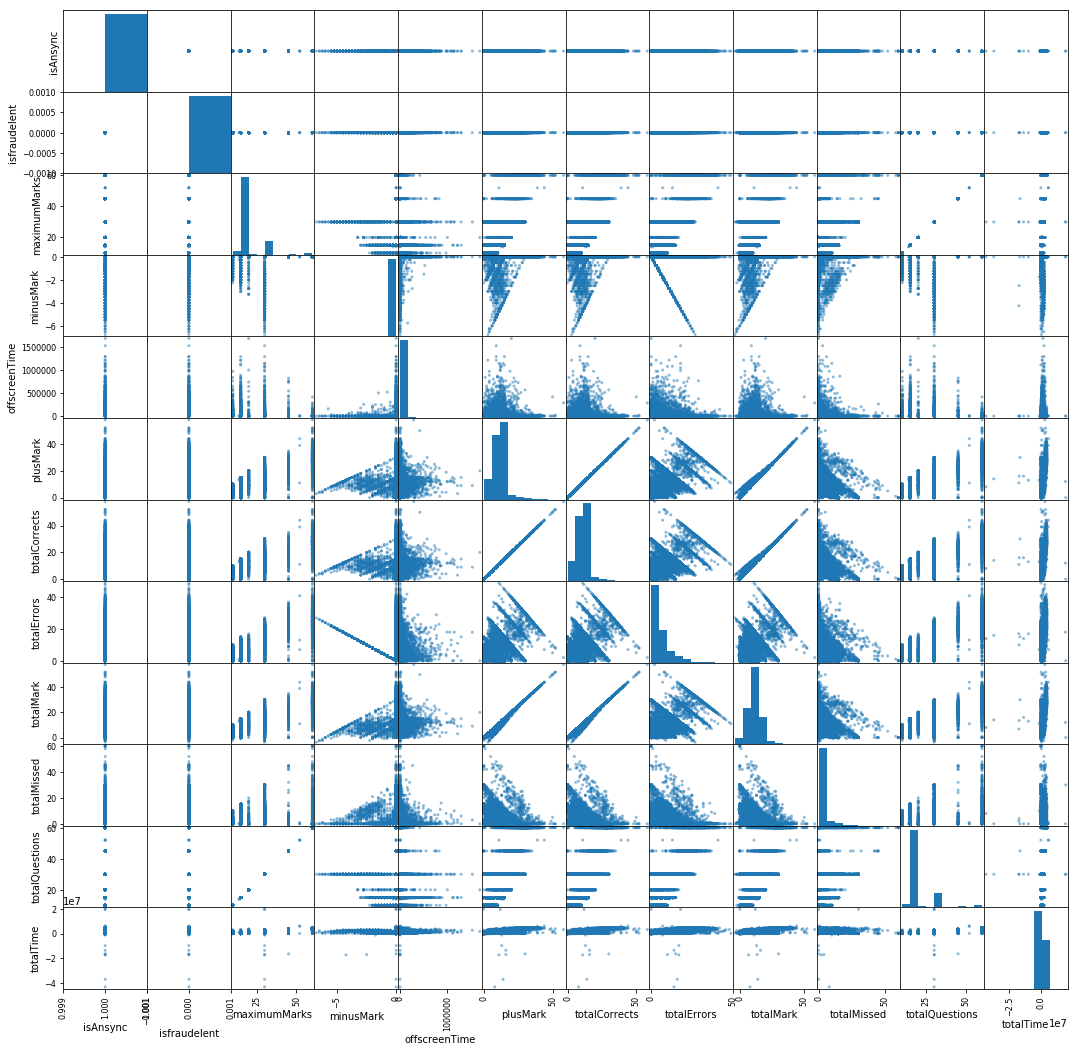

In [47]:
pd.plotting.scatter_matrix(placement_test_df, figsize = (18,18));

In [48]:
# lets see the correlations between features
placement_test_df[['minusMark','totalMissed','totalMark','totalCorrects','totalErrors','offscreenTime','plusMark','totalTime']].corr()

,minusMark,totalMissed,totalMark,totalCorrects,totalErrors,offscreenTime,plusMark,totalTime
minusMark,1.000000,-0.072836,0.130356,0.041819,-0.159065,0.014823,0.041819,-0.093547
totalMissed,-0.072836,1.000000,-0.267965,-0.263513,0.006454,0.019147,-0.263513,0.226292
totalMark,0.130356,-0.267965,1.000000,0.996051,0.048674,0.005979,0.996051,0.296352
totalCorrects,0.041819,-0.263513,0.996051,1.000000,0.063293,0.004698,1.000000,0.307018
totalErrors,-0.159065,0.006454,0.048674,0.063293,1.000000,0.038809,0.063293,0.537850
offscreenTime,0.014823,0.019147,0.005979,0.004698,0.038809,1.000000,0.004698,0.098999
plusMark,0.041819,-0.263513,0.996051,1.000000,0.063293,0.004698,1.000000,0.307018
totalTime,-0.093547,0.226292,0.296352,0.307018,0.537850,0.098999,0.307018,1.000000


from above we can observe following things
1. total missed and totalMark features are negatively corelated, meaning that if the student missed more questions he wil get less total marks.
2. similarly totalMissed and totalCorrects are negatiely corelated, meaning if we student missed more more quesitons totalCorrects will be reduced.
3. There is very high corelation between totalMarks and totalCorrects which obviously show that if student get more corrects then he will get more totalMarks
4. similarily like above one there is very high corelation between plusMark and totalMark
5. Also the plusMark and totalCorrects are highly corelated, which is obvious.
6. there is also 0.30 corelation between totalcorrects and totalTime taken.
7. corelation value of 0.53 exists between totalErrors and totalTime, which is interesting because some students who tootk more time has made more errors.

In [49]:
practicesets_df[['user','totalAttempt','plusMark','totalTime']].corr()

,totalAttempt,plusMark,totalTime
totalAttempt,1.000000,-0.032278,-0.132423
plusMark,-0.032278,1.000000,0.126245
totalTime,-0.132423,0.126245,1.000000


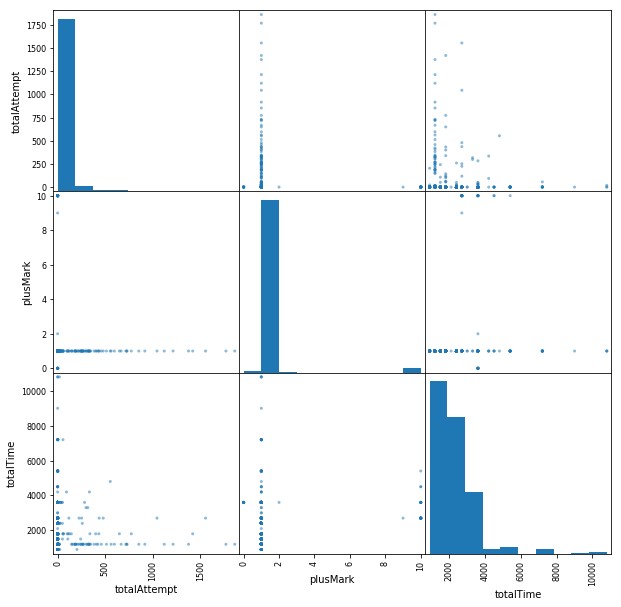

In [50]:
pd.plotting.scatter_matrix(practicesets_df[['user','totalAttempt','plusMark','totalTime']], figsize=(10,10));

#

In [59]:
placement_test_df.user.value_counts().shape

(2938,)

### from above we can see that there are total 2938 unique users
### lets group the placement test dataframe by unique users

In [62]:
placement_test_df.attemptdetails

4994     5bb38e09d00510244a38ac9d
5051     5bb4c961377221c4ab13ef42
4913     5bb24bd65ad18ac1883ddb4d
4910     5bb25c50d00510391038a911
4991     5bb376a53ca2b40e5ee7646d
4985     5bb386ab3ca2b4a923e764f4
4983     5bb384c93ca2b40c8ce764b6
5000     5bb3a127d586b4767105dd98
4897     5bb250913ca2b45d8ee75fc6
4874     5bb2211c5aed8f6d8996dfe2
5095     5bb8f4888cca8d8323e593ba
4979     5bb380663ca2b4e873e76488
5032     5bb4c5de3ca2b48493e77ddb
4880     5bb227543ca2b491d4e75f3a
5001     5bb3a160d00510b4a938ad65
5065     5bb503d13cf4fd506a9ce3fd
4907     5bb2586cd586b4855e05dbd4
4920     5bb26189b4960e160368fe27
4980     5bb380817132fd31dd93d96b
5062     5bb4ffcd8d1c2124001294eb
4996     5bb39da05ad18aa9753ddc5d
5056     5bb4f9e04ca8bf3d99f8348a
4895     5bb24fac6080c1b5f8c35090
5047     5bb4ec773f95a611ebad3804
4888     5bb23e08fe1ba6765b5f037c
4964     5bb34700f7dc46e7493e2149
5055     5bb4f04bf1efbf4f68440fb8
4973     5bb3781c7132fd447f93d73f
4935     5bb265bab4960e5d7468fec2
4914     5bb25

In [66]:
placement_test_df.groupby(['user','userId','_id']).count().head(10)

attemptdetails  \
user                     userId     _id                                        
5b4b99ef083538000d9885d1 9874206286 5bb24bd65ad18a6d943ddb4c               1   
                                    5bb38e09d0051018a438ac9c               1   
                                    5bb4c961377221c4f313ef41               1   
5b4b99ef083538000d9885d7 9811527783 5bb25c50d005109a0f38a910               1   
5b4b99ef083538000d9885d9 7069391727 5bb376a53ca2b485ace7646c               1   
                                    5bb384c93ca2b42100e764b5               1   
                                    5bb386ab3ca2b4019de764f3               1   
5b4b99f0083538000d9885dd 7306782220 5bb250913ca2b43debe75fc5               1   
                                    5bb3a127d586b4cb6d05dd97               1   
5b4b99f0083538000d9885e1 9479826693 5bb2211c5aed8fa22496dfe1               1   

                                                              createdBy.name  \
user                     userId     _id                                        
5b4b99ef083538000d9885d1 9874206286 5bb24bd65ad18a6d943ddb4c               1   
                                    5bb38e09d0051018a438ac9c               1   
                                    5bb4c961377221c4f313ef41               1   
5b4b99ef083538000d9885d7 9811527783 5bb25c50d005109a0f38a910               1   
5b4b99ef083538000d9885d9 7069391727 5bb376a53ca2b485ace7646c               1   
                                    5bb384c93ca2b42100e764b5               1   
                                    5bb386ab3ca2b4019de764f3               1   
5b4b99f0083538000d9885dd 7306782220 5bb250913ca2b43debe75fc5               1   
                                    5bb3a127d586b4cb6d05dd97               1   
5b4b99f0083538000d9885e1 9479826693 5bb2211c5aed8fa22496dfe1               1   

                                                              isAnsync  \
user                     userId     _id                                  
5b4b99ef083538000d9885d1 9874206286 5bb24bd65ad18a6d943ddb4c         1   
                                    5bb38e09d0051018a438ac9c         1   
                                    5bb4c961377221c4f313ef41         1   
5b4b99ef083538000d9885d7 9811527783 5bb25c50d005109a0f38a910         1   
5b4b99ef083538000d9885d9 7069391727 5bb376a53ca2b485ace7646c         1   
                                    5bb384c93ca2b42100e764b5         1   
                                    5bb386ab3ca2b4019de764f3         1   
5b4b99f0083538000d9885dd 7306782220 5bb250913ca2b43debe75fc5         1   
                                    5bb3a127d586b4cb6d05dd97         1   
5b4b99f0083538000d9885e1 9479826693 5bb2211c5aed8fa22496dfe1         1   

                                                              isfraudelent  \
user                     userId     _id                                      
5b4b99ef083538000d9885d1 9874206286 5bb24bd65ad18a6d943ddb4c             1   
                                    5bb38e09d0051018a438ac9c             1   
                                    5bb4c961377221c4f313ef41             1   
5b4b99ef083538000d9885d7 9811527783 5bb25c50d005109a0f38a910             1   
5b4b99ef083538000d9885d9 7069391727 5bb376a53ca2b485ace7646c             1   
                                    5bb384c93ca2b42100e764b5             1   
                                    5bb386ab3ca2b4019de764f3             1   
5b4b99f0083538000d9885dd 7306782220 5bb250913ca2b43debe75fc5             1   
                                    5bb3a127d586b4cb6d05dd97             1   
5b4b99f0083538000d9885e1 9479826693 5bb2211c5aed8fa22496dfe1             1   

                                                              maximumMarks  \
user                     userId     _id                                      
5b4b99ef083538000d9885d1 9874206286 5bb24bd65ad18a6d943ddb4c             1   
                                    5bb38e09d0051018a438ac9c             1   
  

### from above we can see each user has unique userid, and mulipled _id's which implies that 
### How many id's or attemptdetails each user has that many tests corresopnding user has taken.
### So lets counts the number of ids or attemptdetails each user has and create a new dataframe and store a column with name numberOfTests which indicates how many tests each user took

In [68]:
placement_test_df.groupby(['user','userId']).count().head(10)

,,_id,attemptdetails,createdBy.name,isAnsync,isfraudelent,maximumMarks,minusMark,offscreenTime,plusMark,practiceSetInfo.createdBy,practiceSetInfo.grades.name,practiceSetInfo.subject,studentName,subjects,totalCorrects,totalErrors,totalMark,totalMissed,totalQuestions,totalTime
user,userId,,,,,,,,,,,,,,,,,,,,
5b4b99ef083538000d9885d1,9874206286,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
5b4b99ef083538000d9885d7,9811527783,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5b4b99ef083538000d9885d9,7069391727,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
5b4b99f0083538000d9885dd,7306782220,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
5b4b99f0083538000d9885e1,9479826693,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
5b4b99f0083538000d9885e3,9470305915,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
5b4b99f0083538000d9885e5,7357574108,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
5b4b99f0083538000d9885e7,9878273464,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
5b4b99f0083538000d9885e9,9598238782,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3


### From above attemptdetails we can see the number of attempts or tests each user took lets prepare a new dataframe which we can import useful information

In [128]:
numberOfAttempts = placement_test_df.groupby(['user','userId']).count()['attemptdetails']

In [132]:
placement_test_analysis_df = pd.DataFrame(numberOfAttempts).reset_index()

In [133]:
placement_test_analysis_df.head()

,user,userId,attemptdetails
0,5b4b99ef083538000d9885d1,9874206286,3
1,5b4b99ef083538000d9885d7,9811527783,1
2,5b4b99ef083538000d9885d9,7069391727,3
3,5b4b99f0083538000d9885dd,7306782220,2
4,5b4b99f0083538000d9885e1,9479826693,5


In [134]:
attempts_df.columns

Index(['__v', '_id', 'attemptType', 'attemptdetails', 'createdAt',
       'createdBy.name', 'createdBy.user', 'email', 'idOffline', 'isAbandoned',
       'isAnsync', 'isCratedOffline', 'isEvaluated', 'isShowAttempt',
       'isfraudelent', 'maximumMarks', 'minusMark', 'offscreenTime', 'partial',
       'pending', 'plusMark', 'practiceSetInfo.accessMode',
       'practiceSetInfo.classRooms', 'practiceSetInfo.createdBy',
       'practiceSetInfo.grades._id', 'practiceSetInfo.grades.level',
       'practiceSetInfo.grades.name', 'practiceSetInfo.subject',
       'practiceSetInfo.title', 'practiceSetInfo.titleLower', 'practicesetId',
       'studentName', 'subjects', 'totalCorrects', 'totalErrors', 'totalMark',
       'totalMarkeds', 'totalMissed', 'totalQuestions', 'totalTime',
       'updatedAt', 'user', 'userId'],
      dtype='object')

In [139]:
placement_test_df.maximumMarks.mean()

18.271684697427272

In [152]:
numberOfAttempts = placement_test_df.groupby(['user','userId']).count()['attemptdetails']

In [153]:
numberOfAttempts.shape

(2945,)

In [145]:
placement_test_df[placement_test_df['userId'] == '7069391727']

,_id,attemptdetails,createdBy.name,isAnsync,isfraudelent,maximumMarks,minusMark,offscreenTime,plusMark,practiceSetInfo.createdBy,...,studentName,subjects,totalCorrects,totalErrors,totalMark,totalMissed,totalQuestions,totalTime,user,userId
4991,5bb376a53ca2b485ace7646c,5bb376a53ca2b40e5ee7646d,quant baba,True,False,20,0.0,40000,2,5bab4d8d4e70fd1f2b1741d9,...,R oomi,"[{'_id': e8cfb0328cda490ca3e53827, 'name': 'Qu...",2,0,2.0,18,20,648077,5b4b99ef083538000d9885d9,7069391727
4985,5bb386ab3ca2b4019de764f3,5bb386ab3ca2b4a923e764f4,quant baba,True,False,20,0.0,0,3,5bab4d8d4e70fd1f2b1741d9,...,R oomi,"[{'_id': e8cfb0328cda490ca3e53827, 'name': 'Qu...",3,2,3.0,15,20,63339,5b4b99ef083538000d9885d9,7069391727
4983,5bb384c93ca2b42100e764b5,5bb384c93ca2b40c8ce764b6,LPU Admin,True,False,30,0.0,646000,11,5b3778f43331fd000d75e277,...,R oomi,"[{'_id': 3835d8c367564425b162d7db, 'name': 'C ...",11,9,11.0,10,30,3093251,5b4b99ef083538000d9885d9,7069391727


In [81]:
pd.DataFrame(numberOfAttempts)[:5]

,,attemptdetails
user,userId,
5b4b99ef083538000d9885d1,9874206286,3
5b4b99ef083538000d9885d7,9811527783,1
5b4b99ef083538000d9885d9,7069391727,3
5b4b99f0083538000d9885dd,7306782220,2
5b4b99f0083538000d9885e1,9479826693,5


In [110]:
placement_test_analysis_df = pd.DataFrame({'unique_users':unique_users, 'numberOfTestAttempts':})

In [155]:
placement_test_analysis_df.head()

,user,userId,attemptdetails
0,5b4b99ef083538000d9885d1,9874206286,3
1,5b4b99ef083538000d9885d7,9811527783,1
2,5b4b99ef083538000d9885d9,7069391727,3
3,5b4b99f0083538000d9885dd,7306782220,2
4,5b4b99f0083538000d9885e1,9479826693,5


1. now we have numbler of attempts each user has
2. Lets check whether is there any relationship between number of attempts and plusMarks, maximum Marks and minusMark
3. Since the plus marks, minus marks and maximum marks are not same on each test, so lets take average
4. And see the relationship between those and check whether there is any positive corelation between number  of attempts and positive marks, and maximum marks, and also negative corelation between number of attempts and minusMarks
5. Same above relationship holds with totalCorrects, totalErrors, totalMark, totalMissed and totalQuestions.

In [157]:
placement_test_df.groupby(['user','userId']).mean()[['maximumMarks','minusMark','plusMark','totalCorrects','totalErrors','totalMark','totalMissed','totalQuestions','totalTime']].head(10)

,,maximumMarks,minusMark,plusMark,totalCorrects,totalErrors,totalMark,totalMissed,totalQuestions,totalTime
user,userId,,,,,,,,,
5b4b99ef083538000d9885d1,9874206286,20.000000,-0.666667,12.000000,12.000000,8.000000,11.333333,0.000000,20.000000,6.299380e+05
5b4b99ef083538000d9885d7,9811527783,20.000000,0.000000,17.000000,17.000000,2.000000,17.000000,1.000000,20.000000,7.031640e+05
5b4b99ef083538000d9885d9,7069391727,23.333333,0.000000,5.333333,5.333333,3.666667,5.333333,14.333333,23.333333,1.268222e+06
5b4b99f0083538000d9885dd,7306782220,20.000000,0.000000,18.000000,18.000000,2.000000,18.000000,0.000000,20.000000,5.331645e+05
5b4b99f0083538000d9885e1,9479826693,20.000000,-0.250000,13.800000,13.800000,5.400000,13.550000,0.800000,20.000000,9.782934e+05
5b4b99f0083538000d9885e3,9470305915,23.333333,-2.500000,10.000000,10.000000,13.333333,7.500000,0.000000,23.333333,6.195633e+05
5b4b99f0083538000d9885e5,7357574108,20.000000,-0.500000,13.666667,13.666667,6.333333,13.166667,0.000000,20.000000,9.921853e+05
5b4b99f0083538000d9885e7,9878273464,20.000000,-0.416667,14.666667,14.666667,3.333333,14.250000,2.000000,20.000000,1.504782e+06
5b4b99f0083538000d9885e9,9598238782,20.000000,-1.083333,9.666667,9.666667,10.333333,8.583333,0.000000,20.000000,5.963703e+05


In [158]:
placement_test_analysis_mean = placement_test_df.groupby(['user','userId']).mean()[['maximumMarks','minusMark','plusMark','totalCorrects','totalErrors','totalMark','totalMissed','totalQuestions','totalTime']]

## Now lets join placement_test_anlysis_mean with placement_test_analysis_df

In [166]:
placement_test_analysis_mean.reset_index().iloc[:,2:]

,maximumMarks,minusMark,plusMark,totalCorrects,totalErrors,totalMark,totalMissed,totalQuestions,totalTime
0,20.000000,-0.666667,12.000000,12.000000,8.000000,11.333333,0.000000,20.000000,6.299380e+05
1,20.000000,0.000000,17.000000,17.000000,2.000000,17.000000,1.000000,20.000000,7.031640e+05
2,23.333333,0.000000,5.333333,5.333333,3.666667,5.333333,14.333333,23.333333,1.268222e+06
3,20.000000,0.000000,18.000000,18.000000,2.000000,18.000000,0.000000,20.000000,5.331645e+05
4,20.000000,-0.250000,13.800000,13.800000,5.400000,13.550000,0.800000,20.000000,9.782934e+05
5,23.333333,-2.500000,10.000000,10.000000,13.333333,7.500000,0.000000,23.333333,6.195633e+05
6,20.000000,-0.500000,13.666667,13.666667,6.333333,13.166667,0.000000,20.000000,9.921853e+05
7,20.000000,-0.416667,14.666667,14.666667,3.333333,14.250000,2.000000,20.000000,1.504782e+06
8,20.000000,-1.083333,9.666667,9.666667,10.333333,8.583333,0.000000,20.000000,5.963703e+05
9,20.000000,-0.166667,14.000000,14.000000,3.333333,13.833333,2.666667,20.000000,7.834493e+05


In [168]:
placement_test_analysis_df = placement_test_analysis_df.join(placement_test_analysis_mean.reset_index().iloc[:,2:])

In [170]:
placement_test_analysis_df.head(10)

,user,userId,attemptdetails,maximumMarks,minusMark,plusMark,totalCorrects,totalErrors,totalMark,totalMissed,totalQuestions,totalTime
0,5b4b99ef083538000d9885d1,9874206286,3,20.000000,-0.666667,12.000000,12.000000,8.000000,11.333333,0.000000,20.000000,6.299380e+05
1,5b4b99ef083538000d9885d7,9811527783,1,20.000000,0.000000,17.000000,17.000000,2.000000,17.000000,1.000000,20.000000,7.031640e+05
2,5b4b99ef083538000d9885d9,7069391727,3,23.333333,0.000000,5.333333,5.333333,3.666667,5.333333,14.333333,23.333333,1.268222e+06
3,5b4b99f0083538000d9885dd,7306782220,2,20.000000,0.000000,18.000000,18.000000,2.000000,18.000000,0.000000,20.000000,5.331645e+05
4,5b4b99f0083538000d9885e1,9479826693,5,20.000000,-0.250000,13.800000,13.800000,5.400000,13.550000,0.800000,20.000000,9.782934e+05
5,5b4b99f0083538000d9885e3,9470305915,3,23.333333,-2.500000,10.000000,10.000000,13.333333,7.500000,0.000000,23.333333,6.195633e+05
6,5b4b99f0083538000d9885e5,7357574108,3,20.000000,-0.500000,13.666667,13.666667,6.333333,13.166667,0.000000,20.000000,9.921853e+05
7,5b4b99f0083538000d9885e7,9878273464,3,20.000000,-0.416667,14.666667,14.666667,3.333333,14.250000,2.000000,20.000000,1.504782e+06
8,5b4b99f0083538000d9885e9,9598238782,3,20.000000,-1.083333,9.666667,9.666667,10.333333,8.583333,0.000000,20.000000,5.963703e+05
9,5b4b99f0083538000d9885eb,9468615936,3,20.000000,-0.166667,14.000000,14.000000,3.333333,13.833333,2.666667,20.000000,7.834493e+05


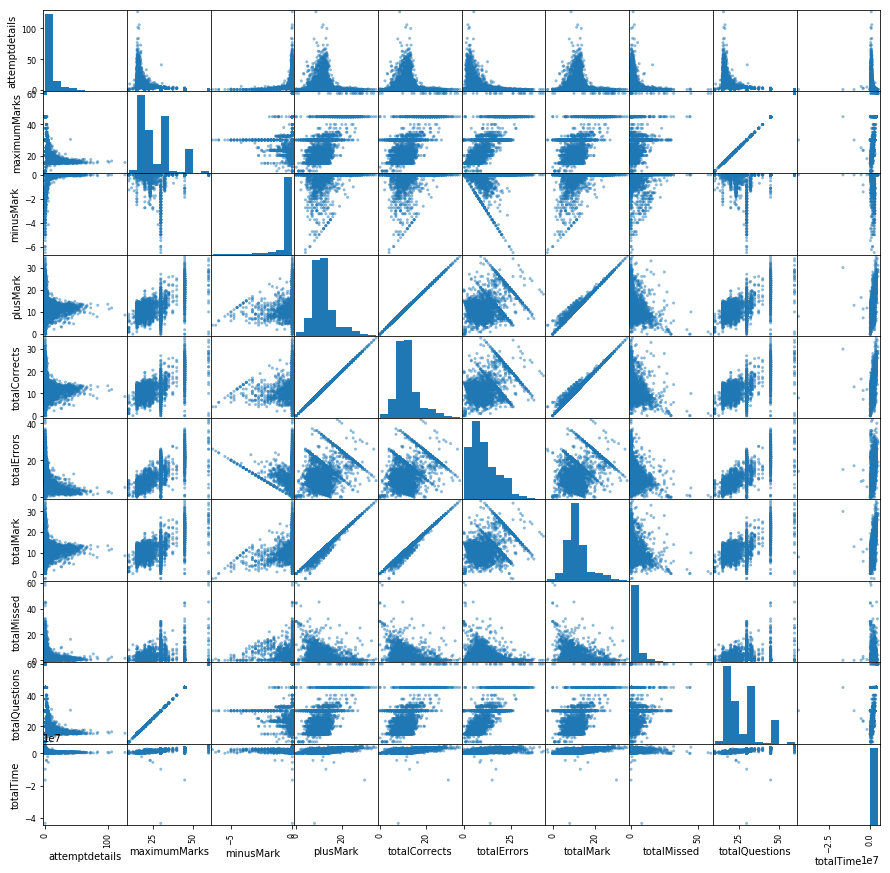

In [172]:
pd.plotting.scatter_matrix(placement_test_analysis_df, figsize=(15,15));

In [173]:
placement_test_analysis_df.corr()

,attemptdetails,maximumMarks,minusMark,plusMark,totalCorrects,totalErrors,totalMark,totalMissed,totalQuestions,totalTime
attemptdetails,1.000000,-0.487393,0.167824,-0.079336,-0.079336,-0.496367,-0.052808,-0.176902,-0.487393,-0.298880
maximumMarks,-0.487393,1.000000,-0.079742,0.588088,0.588088,0.790038,0.560790,0.264387,1.000000,0.529916
minusMark,0.167824,-0.079742,1.000000,0.111335,0.111335,-0.102965,0.253813,-0.121834,-0.079742,-0.082886
plusMark,-0.079336,0.588088,0.111335,1.000000,1.000000,0.294908,0.989498,-0.254663,0.588088,0.383163
totalCorrects,-0.079336,0.588088,0.111335,1.000000,1.000000,0.294908,0.989498,-0.254663,0.588088,0.383163
totalErrors,-0.496367,0.790038,-0.102965,0.294908,0.294908,1.000000,0.272059,-0.157260,0.790038,0.388802
totalMark,-0.052808,0.560790,0.253813,0.989498,0.989498,0.272059,1.000000,-0.265585,0.560790,0.360878
totalMissed,-0.176902,0.264387,-0.121834,-0.254663,-0.254663,-0.157260,-0.265585,1.000000,0.264387,0.111345
totalQuestions,-0.487393,1.000000,-0.079742,0.588088,0.588088,0.790038,0.560790,0.264387,1.000000,0.529916
totalTime,-0.298880,0.529916,-0.082886,0.383163,0.383163,0.388802,0.360878,0.111345,0.529916,1.000000


In [160]:
type(placement_test_analysis_mean)

pandas.core.frame.DataFrame

In [116]:
placement_test_analysis_df.shape

(2938, 1)

In [115]:
unique_userIds.shape

(2939,)

In [88]:
pd.DataFrame(numberOfAttempts)[:5]

,,attemptdetails
user,userId,
5b4b99ef083538000d9885d1,9874206286,3
5b4b99ef083538000d9885d7,9811527783,1
5b4b99ef083538000d9885d9,7069391727,3
5b4b99f0083538000d9885dd,7306782220,2
5b4b99f0083538000d9885e1,9479826693,5


In [72]:
np.array(numberOfAttempts)

array([3, 1, 3, ..., 1, 1, 1], dtype=int64)